# Lake Depth Random Forest model

#### Using:
1. cuDf for data pre-processing
2. cuML for machine learning algorithm implementations
3. Dask for rapids parallelization of GPU code
4. sklearn for metrics

#### Import our model object
Best model is saved

In [21]:
from load_dataset import custom_lakedepth
from models import custom_RF as crf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]
from pprint import pprint

#### Import LakeDepth dataset object
##### Split into training and testing

In [2]:
primary_dataset = custom_lakedepth.LakeDepth(random_state = 42)
covariates_train, covariates_test, labels_train, labels_test = primary_dataset.split(0.20)

 - from DATA: reading csv into GPU memory
 - from DATA: done reading csv into GPU memory
 - from DATA: dropped column: FID
 - from DATA: dropped column: Date


### Random Forest (best model so far) parameters

In [25]:
best_rf_model = crf.load_model('raw_test_01.sav')
pprint(best_rf_model.model.get_params())

{'accuracy_metric': 'mean_ae',
 'bootstrap': True,
 'bootstrap_features': False,
 'handle': <cuml.raft.common.handle.Handle object at 0x7fc0ac2e7df0>,
 'max_batch_size': 128,
 'max_depth': 110,
 'max_features': 'sqrt',
 'max_leaves': -1,
 'min_impurity_decrease': 0.0,
 'min_rows_per_node': 2,
 'n_bins': 6,
 'n_estimators': 1150,
 'output_type': 'cudf',
 'quantile_per_tree': False,
 'rows_sample': 1.0,
 'split_algo': 1,
 'split_criterion': 2,
 'use_experimental_backend': False,
 'verbose': 4}


### Training times (w/ Dask Implementation):
#### with max-depth at sub-80
1.        trees < 500  : 01-02 sec training time
2. 500  < trees < 1000 : 03-04 sec training time
3. 100  < trees < 1500 : 04-05 sec training time
5. 1500 < trees < 2000 : 05-12 sec training time

#### with max-depth at 80+
1.        trees < 500  : 03-04 sec training time
2. 500  < trees < 1000 : 04-09 sec training time
3. 100  < trees < 1500 : 09-15 sec training time
5. 1500 < trees < 2000 : 15-25 sec training time

## Metrics
#### measure the models abilities through
1. Mean Absolute Error
2. r2_score
3. Mean Square Error

In [9]:
predictions, mae, r2, mse = best_rf_model.get_metrics(covariates_test, labels_test)

Scores ------
 MAE:  0.39157444
  r2:  0.840202601744723
 MSE:  0.5075837


-- Still not great on MAE considering the limited range of depths we're working for

## Results Visualization

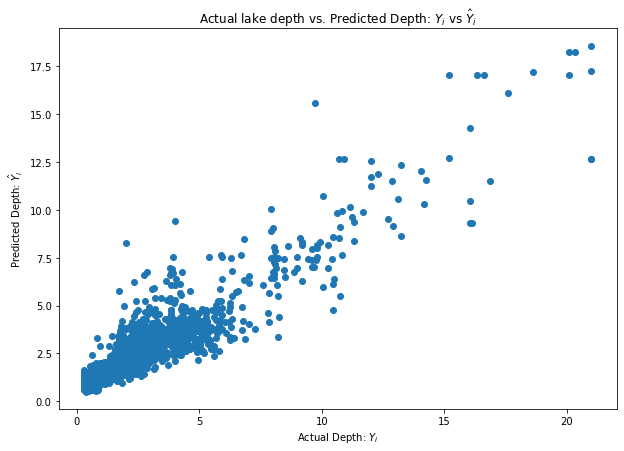

In [26]:
plt.scatter(labels_test.to_array(), predictions.to_array())
plt.xlabel("Actual Depth: $Y_i$")
plt.ylabel("Predicted Depth: $\hat{Y}_i$")
plt.title("Actual lake depth vs. Predicted Depth: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Random sampling of actual vs predicted data

In [12]:
# Lets look at a random sample of datapoints to see the actual vs predicted depths
import random
for i in range(20):
    random_data_point = random.randint(0, 4635)
    print('Data-point: {:5} Actual: {:20} Predicted: {:20}'.format(random_data_point, labels_test.to_array()[random_data_point],
                                               predictions.to_array()[random_data_point]))

Data-point:   598 Actual:   1.9269200563430786 Predicted:    2.297135829925537
Data-point:  2893 Actual:   0.9115560054779053 Predicted:   1.1094872951507568
Data-point:  4093 Actual:    2.084249973297119 Predicted:   2.1085076332092285
Data-point:  2140 Actual:   0.9046429991722107 Predicted:   0.9348396062850952
Data-point:  1833 Actual:   2.2056400775909424 Predicted:    2.063981294631958
Data-point:  2366 Actual:   1.4731999635696411 Predicted:   1.6351839303970337
Data-point:  4333 Actual:   0.5170000195503235 Predicted:   1.1460553407669067
Data-point:  1628 Actual:   2.3083300590515137 Predicted:    6.209043979644775
Data-point:   112 Actual:   1.7484500408172607 Predicted:   1.8336858749389648
Data-point:  2038 Actual:   1.6403299570083618 Predicted:   2.0214388370513916
Data-point:  3098 Actual:    2.168149948120117 Predicted:   3.0056867599487305
Data-point:  3273 Actual:    1.554419994354248 Predicted:   1.6191328763961792
Data-point:  4492 Actual:    1.389799952507019 Predi

## Feature Importance

Using sklearn's permutation importance


Variables: b32_LC8_07           Importance: -0.04106
Variables: b16_LC8_07           Importance: -0.04114
Variables: b15_LC8_07           Importance: -0.04279
Variables: b27_LC8_07           Importance: -0.04325
Variables: b4_LC8_075           Importance: -0.04418
Variables: b31_LC8_07           Importance: -0.0451
Variables: b35_LC8_07           Importance: -0.04638
Variables: b28_LC8_07           Importance: -0.04749
Variables: b6_LC8_075           Importance: -0.05101
Variables: b14_LC8_07           Importance: -0.05281
Variables: b22_LC8_07           Importance: -0.05361
Variables: b33_LC8_07           Importance: -0.05367
Variables: b21_LC8_07           Importance: -0.05583
Variables: b9_LC8_075           Importance: -0.0588
Variables: b5_LC8_075           Importance: -0.06539
Variables: b30_LC8_07           Importance: -0.06754
Variables: b34_LC8_07           Importance: -0.06889
Variables: b2_LC8_075           Importance: -0.07304
Variables: b23_LC8_07           Importance: -0.0

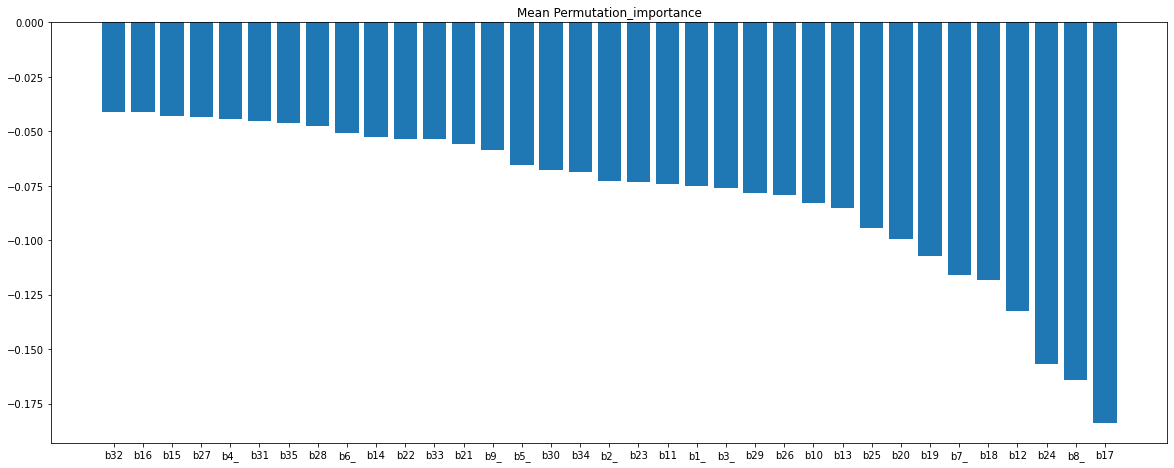

In [27]:
best_rf_model.feature_importances(covariates_train, labels_train, show = True)

## Final Points

* Dask combined with cuDF/cuML is still experimental
* We see significant speedups during training time